# Start Pooling

In [217]:
#import general packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import dirichlet
import scipy.optimize as sco
import random
from pathlib import Path
import pickle

%load_ext autoreload
%autoreload 2
import n_fct_t_rl_thm_ll as bond_fct
import prem_ibrd as prib
import functions as fct

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [218]:
# Function to calculate portfolio risk (standard deviation)
def portfolio_risk(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Function to calculate portfolio return
def portfolio_return(weights, mean_returns):
        return np.sum(weights * mean_returns)

# Function for optimization: minimize risk for a given return
def minimize_risk(target_return, mean_returns, cov_matrix):
    # Number of assets in the portfolio
    num_assets = len(mean_returns)
    # Constraints: weights sum to 1, and portfolio return equals target return
    constraints = ({
        'type': 'eq', 'fun': lambda w: np.sum(w) - 1  # Weights sum to 1
    }, {
        'type': 'eq', 'fun': lambda w: portfolio_return(w, mean_returns) - target_return  # Target return constraint
    })
    # Initial guess: equal weights
    initial_guess = np.ones(num_assets) / num_assets
    # Bounds for weights: between 0 and 1
    bounds = tuple((0, 1) for asset in range(num_assets))
    # Minimize risk (objective function)
    result = sco.minimize(portfolio_risk, initial_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x, result.fun  # Return the optimized weights and the minimized risk

## Define Countries and Variables for Cat Bond Development

In [219]:
#choose country
countries = [480, 212, 882, 332, 670, 388, 662, 214, 548, 242, 776, 174, 584] #[480, 212, 332, 670, 28, 388, 52, 662, 659, 308, 214, 44, 882, 548, 242, 780, 192, 570, 84, 776, 90, 174, 184, 584, 585]
countries_iso_str = ['480', '212', '882', '332', '670', '388', '662', '214', '548', '242', '776', '174', '584']
countries_150 = [332, 388, 214, 44, 548, 192, 84, 90] 
fiji = [242]
countries_30 = [480, 212, 670, 28, 52, 662, 659, 308, 882, 780, 570, 776, 174, 184, 584, 585]

countries_str = ['MUS', 'DMA', 'WSM', 'HTI', 'VCT', 'JAM', 'LCA', 'DOM', 'VUT', 'FJI', 'TON', 'COM', 'MHL']
countries_str_x_label = ['MUS', 'DMA', 'WSM', 'HTI', 'VCT', 'JAM', 'LCA', 'DOM', 'VUT', 'TON', 'COM', 'MHL', 'Pool']

scenario_2 = [[480, 882, 332, 670, 388, 662, 548, 242, 776, 584], [212, 214, 174]]


#set risk free rate, either single value or array
rf_rates = 0.00
#set risk muliplier reported by artems
artemis_multiplier = 4.54
#set sharpe ratio to beat
target_sharpe = 0.5
#inititate IBRD premium calculation function
params_ibrd = prib.init_prem_ibrd(file_path=Path("C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis"),want_plot=False)
a, k, b = params_ibrd
#define bond setting
lower_share = 0.05
prot_rp = 250


## Designe Multi-Country Bond
### Set Variables for Multi-Country Bond

In [220]:
sng_ann_ret_df_ibrd = pd.read_csv("C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis/simulation_results/sng_returns_ibrd.csv")[countries_iso_str]
sng_ann_ret_df_regression = pd.read_csv("C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis/simulation_results/sng_returns_regression.csv")[countries_iso_str]
sng_ann_ret_df_artemis = pd.read_csv("C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis/simulation_results/sng_returns_artemis.csv")[countries_iso_str]
sng_ann_ret_df_required = pd.read_csv("C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis/simulation_results/sng_returns_required.csv")[countries_iso_str]
output_path = Path("C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis/simulation_results/bond_metrics_sng_dic.pkl")
with open(output_path, "rb") as file:
    bond_metrics_sng_dic = pickle.load(file)

bond_metrics_sng_dic = {key: bond_metrics_sng_dic[key] for key in countries}

sng_ann_ret_required = sng_ann_ret_df_required.to_dict('series')
sng_ann_ret_artemis = sng_ann_ret_df_artemis.to_dict('series')
sng_ann_ret_regression = sng_ann_ret_df_regression.to_dict('series')
sng_ann_ret_ibrd = sng_ann_ret_df_ibrd.to_dict('series')

nominal_sng_dic_df = pd.read_csv("C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis/simulation_results/nominal_dic_df.csv")
# Specify the output path
output_path = Path("C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis/simulation_results/pay_dam_df_dic.pkl")
with open(output_path, "rb") as file:
    pay_dam_df_sng_dic = pickle.load(file)
pay_dam_df_sng_dic = {key: pay_dam_df_sng_dic[key] for key in countries}

nominal_sng_dic = dict(zip(nominal_sng_dic_df["Key"], nominal_sng_dic_df["Value"]))
nominal_sng_dic = {key: nominal_sng_dic[key] for key in countries}

### Create Multi-Country bond

In [221]:
tranches_array = np.array([50, 250, 1000])

ncf_s2 = {}
premiums_s2 = {}
premium_dic_s2 = {}
nominal_s2 = {}
es_metrics_s2 = {}
MES_cty_s2 = {}
tranches_s2 = {}

i = 0
for pool in scenario_2:
    i += 1
    if len(pool) > 1:
        nominal_dic_pool = {}
        pay_dam_df_dic_pool = {}
        for cty in pool:
            nominal_dic_pool[cty] = nominal_sng_dic[cty]
            pay_dam_df_dic_pool[cty] = pay_dam_df_sng_dic[cty]
        ncf_s2[str(i)], premiums_s2[str(i)], premium_dic_s2[str(i)], nominal_s2[str(i)], es_metrics_s2[str(i)], MES_cty_s2[str(i)], tranches_s2[str(i)] = bond_fct.mlt_cty_bond(countries=pool,pay_dam_df_dic=pay_dam_df_dic_pool,
                                                                                                                                                                         nominals_dic=nominal_dic_pool, tranches_array=tranches_array, 
                                                                                                                                                                         opt_cap=True, ibrd_path=Path("C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis"),
                                                                                                                                                                         peak_multi=0)

c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 23.76%


c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 0.62%


In [222]:
s2_tranches_ann_ret_regr = {}
s2_tranches_ann_ret_ibrd = {}
s2_tranches_ann_ret_requ = {}
s2_tranches_ann_ret_arte = {}

for key in ncf_s2["1"]['regression']:
    if key != 'Total':
        for pool in ncf_s2:
            s2_tranches_ann_ret_regr[f"{pool}: {key}"] = ncf_s2[pool]['regression'][key] / tranches_s2[pool].loc[tranches_s2[pool]['RP'] == key, 'nominal'].iloc[0]
            s2_tranches_ann_ret_ibrd[f"{pool}: {key}"] = ncf_s2[pool]['ibrd'][key] / tranches_s2[pool].loc[tranches_s2[pool]['RP'] == key, 'nominal'].iloc[0]
            s2_tranches_ann_ret_requ[f"{pool}: {key}"] = ncf_s2[pool]['required'][key] / tranches_s2[pool].loc[tranches_s2[pool]['RP'] == key, 'nominal'].iloc[0]
            s2_tranches_ann_ret_arte[f"{pool}: {key}"] = ncf_s2[pool]['artemis'][key] / tranches_s2[pool].loc[tranches_s2[pool]['RP'] == key, 'nominal'].iloc[0]

i = 0
for pool in scenario_2:
    i += 1
    if len(pool) == 1:
        s2_tranches_ann_ret_regr[str(i)] = sng_ann_ret_regression[str(pool[0])]
        s2_tranches_ann_ret_ibrd[str(i)] = sng_ann_ret_ibrd[str(pool[0])]
        s2_tranches_ann_ret_requ[str(i)] = sng_ann_ret_required[str(pool[0])]
        s2_tranches_ann_ret_arte[str(i)] = sng_ann_ret_artemis[str(pool[0])]

s2_ann_ret_regr = {}
s2_ann_ret_ibrd = {}
s2_ann_ret_requ = {}
s2_ann_ret_arte = {}
for pool in ncf_s2:
    s2_ann_ret_regr[pool] = 0
    s2_ann_ret_ibrd[pool] = 0
    s2_ann_ret_requ[pool] = 0
    s2_ann_ret_arte[pool] = 0
    for rp in ncf_s2[pool]['regression']:
        if rp != 'Total':
            s2_ann_ret_regr[pool] += ncf_s2[pool]['regression'][rp]
            s2_ann_ret_ibrd[pool] += ncf_s2[pool]['ibrd'][rp]
            s2_ann_ret_requ[pool] += ncf_s2[pool]['required'][rp]
            s2_ann_ret_arte[pool] += ncf_s2[pool]['artemis'][rp]

i = 0
for pool in scenario_2:
    i += 1
    if len(pool) == 1:
        s2_ann_ret_regr[str(i)] = sng_ann_ret_regression[str(pool[0])]
        s2_ann_ret_ibrd[str(i)] = sng_ann_ret_ibrd[str(pool[0])]
        s2_ann_ret_requ[str(i)] = sng_ann_ret_required[str(pool[0])]
        s2_ann_ret_arte[str(i)] = sng_ann_ret_artemis[str(pool[0])]

Sng Premiums ibrd: 2545245655.6858907
S2 Premiums ibrd: 2171792207.6580734; 0.8532741045275729
Sng Premiums required: 3985872869.7134085
S2 Premiums required: 3555235072.308859; 0.8919589732335057
Sng Premiums regression: 3406108990.4094887
S2 Premiums regression: 3205560568.976425; 0.9411209617784564
Sng Nominal: 43630876300.25018
S2 Nominal: 39094387599.45369; 0.8960257256907196


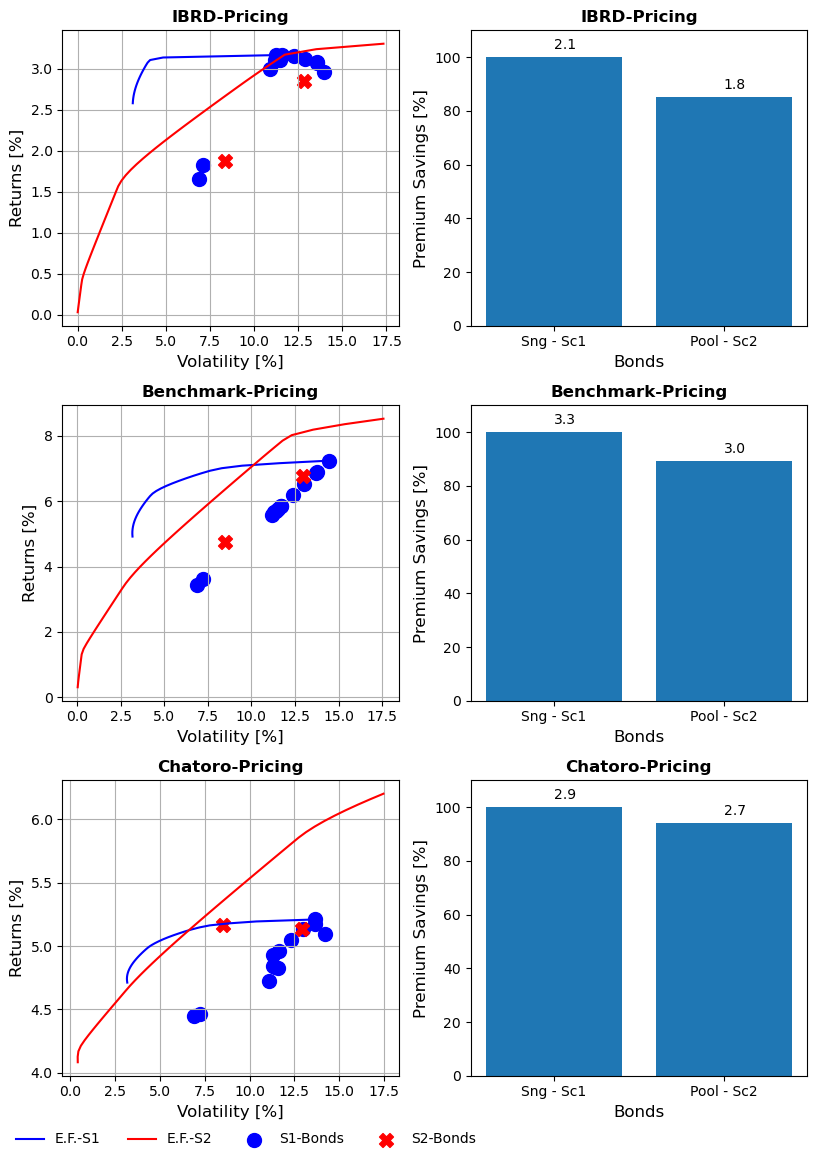

In [238]:
premiums_abs_keys = ['Sng', 'S2']
premiums_abs = {key: {} for key in premiums_abs_keys}
premium_methods = ['ibrd', 'required', 'regression']
premium_methods_title = ['IBRD-Pricing', 'Benchmark-Pricing', 'Chatoro-Pricing']
num_plots = len(premium_methods)
fig, axes = plt.subplots(num_plots, 2, figsize=(8.27, 4 * num_plots)) 

for j, prem_mode in enumerate(premium_methods): 
    premiums_pool_s2 = {}
    for pool, prem_modes in premiums_s2.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s2:  # If the key already exists, sum the values
                    premiums_pool_s2[key] += np.sum(values * nominal_s2[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s2[key] = np.sum(values * nominal_s2[pool])
            
    if prem_mode == 'ibrd':
        sng_ann_ret = sng_ann_ret_ibrd
        sng_ann_ret_df = sng_ann_ret_df_ibrd
        s2_tranches_ann_ret_df = s2_tranches_ann_ret_ibrd
        s2_ann_ret = s2_ann_ret_ibrd
        sng_cty_premium = []
        sng_cty_pay = []
        for cty in bond_metrics_sng_dic:
            sng_cty_premium.append(bond_metrics_sng_dic[cty]['Total Premiums'][0])
            sng_cty_pay.append(bond_metrics_sng_dic[cty]['Summed Payments'][0])
        for pool in scenario_2:
            if len(pool) == 1:
                premiums_pool_s2['Total_alt'] += bond_metrics_sng_dic[pool[0]]['Total Premiums'][0]
                premiums_pool_s2[pool[0]] = bond_metrics_sng_dic[pool[0]]['Total Premiums'][0]
        threshold_ef = 0.0255

    elif prem_mode == 'regression':
        sng_ann_ret = sng_ann_ret_regression
        sng_ann_ret_df = sng_ann_ret_df_regression
        s2_tranches_ann_ret_df = s2_tranches_ann_ret_regr
        s2_ann_ret = s2_ann_ret_regr
        sng_cty_premium = []
        sng_cty_pay = []
        for cty in bond_metrics_sng_dic:
            sng_cty_premium.append(bond_metrics_sng_dic[cty]['Total Premiums'][1])
            sng_cty_pay.append(bond_metrics_sng_dic[cty]['Summed Payments'][1])
        for pool in scenario_2:
            if len(pool) == 1:
                premiums_pool_s2['Total_alt'] += bond_metrics_sng_dic[pool[0]]['Total Premiums'][1]
                premiums_pool_s2[pool[0]] = bond_metrics_sng_dic[pool[0]]['Total Premiums'][1]
        threshold_ef = 0.047

    elif prem_mode == 'required':
        sng_ann_ret = sng_ann_ret_required
        sng_ann_ret_df = sng_ann_ret_df_required
        s2_tranches_ann_ret_df = s2_tranches_ann_ret_requ
        s2_ann_ret = s2_ann_ret_requ
        sng_cty_premium = []
        sng_cty_pay = []
        for cty in bond_metrics_sng_dic:
            sng_cty_premium.append(bond_metrics_sng_dic[cty]['Total Premiums'][2])
            sng_cty_pay.append(bond_metrics_sng_dic[cty]['Summed Payments'][2])
        for pool in scenario_2:
            if len(pool) == 1:
                premiums_pool_s2['Total_alt'] += bond_metrics_sng_dic[pool[0]]['Total Premiums'][2]
                premiums_pool_s2[pool[0]] = bond_metrics_sng_dic[pool[0]]['Total Premiums'][2]
        threshold_ef = 0.049
    else:
        print('Wrong input premium mode')
        break

    df_returns = pd.DataFrame({f"{country} Returns": returns for country, returns in sng_ann_ret.items()})
    df_returns_s2 = pd.DataFrame({f"{country} Returns": returns for country, returns in s2_tranches_ann_ret_df.items()}).dropna(axis=1)

    r = np.mean(df_returns,axis=0)
    r_s2= np.mean(df_returns_s2,axis=0)

    # Create a covariance matrix
    covar = df_returns.cov()
    covar_s2 = df_returns_s2.cov()

    # Generate a series of target returns and corresponding risks
    target_returns = np.linspace(np.min(r), np.max(r), 50)  # Range of target returns
    risks = []
    for target_return in target_returns:
        weights, risk = minimize_risk(target_return, r, covar)
        risks.append(risk)

    risks_s2 = []
    target_returns_s2 = np.linspace(np.min(r_s2), np.max(r_s2), 50)
    for target_return in target_returns_s2:
        weights, risk = minimize_risk(target_return, r_s2, covar_s2)
        risks_s2.append(risk)

    filtered_target_returns = [value for value in target_returns if value > threshold_ef]
    filtered_risks = [risks[i] for i in range(len(target_returns)) if target_returns[i] > threshold_ef]
    axes[j, 0].plot(np.array(filtered_risks)*100, np.array(filtered_target_returns)*100, label="E.F.-S1", color='blue')
    axes[j, 0].plot(np.array(risks_s2)*100, np.array(target_returns_s2)*100, label="E.F.-S2", color='red')

    for i, cty in enumerate(countries):
        if i == 0:
            axes[j, 0].scatter(np.std(sng_ann_ret[str(cty)])*100, np.mean(sng_ann_ret[str(cty)])*100, color='blue', label='S1-Bonds', s=100)
        else:
            axes[j, 0].scatter(np.std(sng_ann_ret[str(cty)])*100, np.mean(sng_ann_ret[str(cty)])*100, color='blue', s=100)
    for pool in s2_ann_ret:
        if pool == '1':
            axes[j, 0].scatter(np.std(s2_ann_ret[pool])*100, np.mean(s2_ann_ret[pool])*100, color='red', label=f'S2-Bonds', marker='X', s=100)
        else:
            axes[j, 0].scatter(np.std(s2_ann_ret[pool])*100, np.mean(s2_ann_ret[pool])*100, color='red', marker='X', s=100)
    axes[j, 0].set_xlabel("Volatility [%]", fontsize=12)
    axes[j, 0].set_ylabel("Returns [%]", fontsize=12)
    axes[j, 0].grid(True)
    axes[j, 0].set_title(f"{premium_methods_title[j]}", fontsize=12, fontweight='bold')


    x_labels = ["Sng - Sc1", "Pool - Sc2"]
    s_pool = []
    n = []
    s = sng_cty_premium
    prem_diff = [np.sum(s)/np.sum(s), 
                 np.sum(premiums_pool_s2['Total_alt'])/np.sum(s)]

    tot_pay_s2 = 0
    for pool in es_metrics_s2:
        tot_pay_s2 += es_metrics_s2[pool]['Payout']
    for pool in scenario_2:
        if len(pool) == 1:
            tot_pay_s2 += bond_metrics_sng_dic[pool[0]]['Summed Payments'][0]

    im = [np.sum(s)/np.sum(sng_cty_pay), 
          np.sum(premiums_pool_s2['Total_alt'])/tot_pay_s2]

    for q in range(len(im)):
        axes[j, 1].text(x_labels[q], prem_diff[q]*100+3, round(im[q],1))
    axes[j, 1].bar(x_labels, np.array(prem_diff)*100, label='Premium Savings')
    axes[j, 1].set_xlabel("Bonds", fontsize=12)
    axes[j, 1].set_ylabel("Premium Savings [%]", fontsize=12)
    axes[j, 1].set_ylim(0, 110)
    axes[j, 1].tick_params(axis='y')
    axes[j, 1].set_title(f"{premium_methods_title[j]}", fontsize=12, fontweight='bold')
    
    premiums_abs['Sng'][prem_mode] = np.sum(sng_cty_premium)/len(sng_ann_ret['212'])
    premiums_abs['S2'][prem_mode] = premiums_pool_s2['Total_alt']/len(sng_ann_ret['212'])

    print(f"Sng Premiums {prem_mode}: {premiums_abs['Sng'][prem_mode]}")
    print(f"S2 Premiums {prem_mode}: {premiums_abs['S2'][prem_mode]}; {premiums_abs['S2'][prem_mode] / premiums_abs['Sng'][prem_mode]}")
nominal_sng = 0
for key in nominal_sng_dic:
    nominal_sng += nominal_sng_dic[key]
print(f"Sng Nominal: {nominal_sng}")
nominal_pool_s2 = 0
for key in nominal_s2:
    nominal_pool_s2 += nominal_s2[key]
for pool in scenario_2:
    if len(pool) == 1:
        nominal_pool_s2 += nominal_sng_dic[pool[0]]
print(f"S2 Nominal: {nominal_pool_s2}; {nominal_pool_s2 / nominal_sng}")



handles0, labels0 = axes[j, 0].get_legend_handles_labels()
fig.legend(
    handles0,
    labels0,
    loc='lower left',
    bbox_to_anchor=(0.01, 0.03),
    ncol=4,
    frameon=False,
)

#handles1, labels1 = axes[j, 1].get_legend_handles_labels()  
#fig.legend(
#    handles1,
#    labels1,
#    loc='lower right',
#    bbox_to_anchor=(0.90, 0.03),
#    ncol=1,
#    frameon=False
#)

# Adjust layout
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


In [224]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit


# Example data
risk_nor = np.array([0.02, 9.54, 4.80, 6.74, 17.83])  # Avoid zero to prevent issues
returns_nor = np.array([0.02, 4.29, 3.99, 4.42, 8.05])
labels = ["", "Ren. Infrastructure", "Fixed Income", "Real Estate", "Equity"]

# Define the power law function
def power_law_func(x, a, b):
    return a * x**b

# Fit the power law function to the data
params, _ = curve_fit(power_law_func, risk_nor, returns_nor, maxfev=10000)
a, b = params

# Generate smooth values for the trendline
smooth_risk = np.linspace(0, max(risk_nor), 100)
smooth_trendline = power_law_func(smooth_risk, a, b)


offsets = [
    (0.3, -0.05),  # Risk Free (move right and slightly down)
    (0.4, 0.0),  # Fixed Income (move left and up)
    (-0.3, -0.2),   # Real Estate (move right and up)
    (-0.5, -0.15), # Ren. Infrastructure (move left and down)
    (-0.3, -0.05)      # Equity (move up)
]

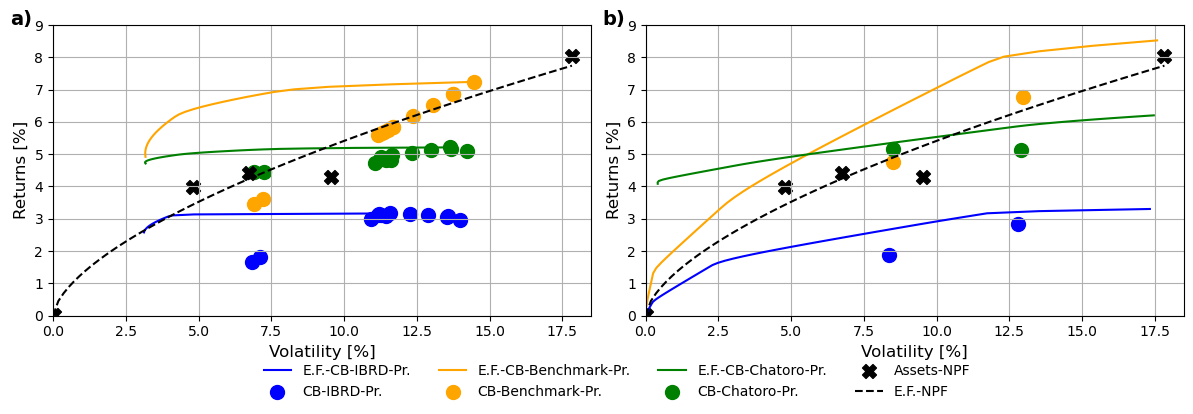

In [225]:
premium_methods = ['ibrd', 'required', 'regression'] #'artemis'
premium_methods_title = ['IBRD-Pr.', 'Benchmark-Pr.', 'Chatoro-Pr.'] #'Artemis-Pricing'
cmap = ['blue', 'orange', 'green']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # 2 columns for function and derivative

for j, prem_mode in enumerate(premium_methods): 
    premiums_pool_s2 = {}
    for pool, prem_modes in premiums_s2.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s2:  # If the key already exists, sum the values
                    premiums_pool_s2[key] += np.sum(values * nominal_s2[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s2[key] = np.sum(values * nominal_s2[pool])
            
    if prem_mode == 'ibrd':
        sng_ann_ret = sng_ann_ret_ibrd
        sng_ann_ret_df = sng_ann_ret_df_ibrd
        s2_tranches_ann_ret_df = s2_tranches_ann_ret_ibrd
        s2_ann_ret = s2_ann_ret_ibrd
        sng_cty_premium = []
        sng_cty_pay = []
        for cty in bond_metrics_sng_dic:
            sng_cty_premium.append(bond_metrics_sng_dic[cty]['Total Premiums'][0])
            sng_cty_pay.append(bond_metrics_sng_dic[cty]['Summed Payments'][0])
        for pool in scenario_2:
            if len(pool) == 1:
                premiums_pool_s2['Total_alt'] += bond_metrics_sng_dic[pool[0]]['Total Premiums'][0]
                premiums_pool_s2[pool[0]] = bond_metrics_sng_dic[pool[0]]['Total Premiums'][0]
        threshold_ef = 0.0255

    elif prem_mode == 'regression':
        sng_ann_ret = sng_ann_ret_regression
        sng_ann_ret_df = sng_ann_ret_df_regression
        s2_tranches_ann_ret_df = s2_tranches_ann_ret_regr
        s2_ann_ret = s2_ann_ret_regr
        sng_cty_premium = []
        sng_cty_pay = []
        for cty in bond_metrics_sng_dic:
            sng_cty_premium.append(bond_metrics_sng_dic[cty]['Total Premiums'][1])
            sng_cty_pay.append(bond_metrics_sng_dic[cty]['Summed Payments'][1])
        for pool in scenario_2:
            if len(pool) == 1:
                premiums_pool_s2['Total_alt'] += bond_metrics_sng_dic[pool[0]]['Total Premiums'][1]
                premiums_pool_s2[pool[0]] = bond_metrics_sng_dic[pool[0]]['Total Premiums'][1]
        threshold_ef = 0.047

    elif prem_mode == 'artemis':
        sng_ann_ret = sng_ann_ret_artemis
        sng_ann_ret_df = sng_ann_ret_df_artemis
        s2_tranches_ann_ret_df = s2_tranches_ann_ret_arte
        s2_ann_ret = s2_ann_ret_arte
        sng_cty_premium = []
        sng_cty_pay = []
        for cty in bond_metrics_sng_dic:
            sng_cty_premium.append(bond_metrics_sng_dic[cty]['Total Premiums'][3])
            sng_cty_pay.append(bond_metrics_sng_dic[cty]['Summed Payments'][3])
        for pool in scenario_2:
            if len(pool) == 1:
                premiums_pool_s2['Total_alt'] += bond_metrics_sng_dic[pool[0]]['Total Premiums'][3]
                premiums_pool_s2[pool[0]] = bond_metrics_sng_dic[pool[0]]['Total Premiums'][3]

    elif prem_mode == 'required':
        sng_ann_ret = sng_ann_ret_required
        sng_ann_ret_df = sng_ann_ret_df_required
        s2_tranches_ann_ret_df = s2_tranches_ann_ret_requ
        s2_ann_ret = s2_ann_ret_requ
        sng_cty_premium = []
        sng_cty_pay = []
        for cty in bond_metrics_sng_dic:
            sng_cty_premium.append(bond_metrics_sng_dic[cty]['Total Premiums'][2])
            sng_cty_pay.append(bond_metrics_sng_dic[cty]['Summed Payments'][2])
        for pool in scenario_2:
            if len(pool) == 1:
                premiums_pool_s2['Total_alt'] += bond_metrics_sng_dic[pool[0]]['Total Premiums'][2]
                premiums_pool_s2[pool[0]] = bond_metrics_sng_dic[pool[0]]['Total Premiums'][2]
        threshold_ef = 0.049
    else:
        print('Wrong input premium mode')
        break

    df_returns = pd.DataFrame({f"{country} Returns": returns for country, returns in sng_ann_ret.items()})
    df_returns_s2 = pd.DataFrame({f"{country} Returns": returns for country, returns in s2_tranches_ann_ret_df.items()}).dropna(axis=1)

    r = np.mean(df_returns,axis=0)
    r_s2= np.mean(df_returns_s2,axis=0)

    # Create a covariance matrix
    covar = df_returns.cov()
    covar_s2 = df_returns_s2.cov()

    # Generate a series of target returns and corresponding risks
    target_returns = np.linspace(np.min(r), np.max(r), 50)  # Range of target returns
    risks = []
    for target_return in target_returns:
        weights, risk = minimize_risk(target_return, r, covar)
        risks.append(risk)

    risks_s2 = []
    target_returns_s2 = np.linspace(np.min(r_s2), np.max(r_s2), 50)
    for target_return in target_returns_s2:
        weights, risk = minimize_risk(target_return, r_s2, covar_s2)
        risks_s2.append(risk)

    filtered_target_returns = [value for value in target_returns if value > threshold_ef]
    filtered_risks = [risks[i] for i in range(len(target_returns)) if target_returns[i] > threshold_ef]
    ax1.plot(np.array(filtered_risks)*100, np.array(filtered_target_returns)*100, label=f"E.F.-CB-{premium_methods_title[j]}", color=cmap[j])
    for i, cty in enumerate(countries):
        if i == 0:
            ax1.scatter(np.std(sng_ann_ret[str(cty)])*100, np.mean(sng_ann_ret[str(cty)])*100, color=cmap[j], label=f'CB-{premium_methods_title[j]}', s=100)
        else:
            ax1.scatter(np.std(sng_ann_ret[str(cty)])*100, np.mean(sng_ann_ret[str(cty)])*100, color=cmap[j] , s=100)

    ax2.plot(np.array(risks_s2)*100, np.array(target_returns_s2)*100, label=f"E.F.-CB-{premium_methods_title[j]}", color=cmap[j])
    for pool in s2_ann_ret:
        if pool == '1':
            ax2.scatter(np.std(s2_ann_ret[pool])*100, np.mean(s2_ann_ret[pool])*100, color=cmap[j], label=f'CB-{premium_methods_title[j]}', s=100)
        else:
            ax2.scatter(np.std(s2_ann_ret[pool])*100, np.mean(s2_ann_ret[pool])*100, color=cmap[j], s=100)


ax1.scatter(risk_nor, returns_nor, marker='X', color='black', label='Assets-NPF', s=100)
#for i, label in enumerate(labels):
#    if i // 2 ==0:
#        ax1.text(risk_nor[i] + offsets[i][0], returns_nor[i] + offsets[i][1], label, fontsize=11,
#                 ha='left')
#    else:
#        ax1.text(risk_nor[i] + offsets[i][0], returns_nor[i] + offsets[i][1], label, fontsize=11,
#                 ha='right')
ax1.plot(smooth_risk, smooth_trendline, color='black', linestyle='--', label="E.F.-NPF")

ax1.set_xlabel("Volatility [%]", fontsize=12)
ax1.set_ylabel("Returns [%]", fontsize=12)
ax1.grid(True)
ax1.set_xlim(0.0, 18.5)
ax1.set_ylim(0.0, 9.0)

ax2.scatter(risk_nor, returns_nor, marker='X', color='black', label='Assets-NPF', s=100)
#for i, label in enumerate(labels):
#    if i // 2 ==0:
#        ax2.text(risk_nor[i] + offsets[i][0], returns_nor[i] + offsets[i][1], label, fontsize=11,
#                 ha='left')
#    else:
#        ax2.text(risk_nor[i] + offsets[i][0], returns_nor[i] + offsets[i][1], label, fontsize=11,
#                 ha='right')
ax2.plot(smooth_risk, smooth_trendline, color='black', linestyle='--', label="E.F.-NPF")

ax2.set_xlabel("Volatility [%]", fontsize=12)
ax2.set_ylabel("Returns [%]", fontsize=12)
ax2.grid(True)
ax2.set_xlim(0.0, 18.5)
ax2.set_ylim(0.0, 9.0)

#ax1.legend()
#ax2.legend()
handles1, labels1 = ax1.get_legend_handles_labels()  
fig.legend(
    handles1,
    labels1,
    loc='lower right',
    bbox_to_anchor=(0.82, -0.04),
    ncol=4,
    frameon=False
)

panel_labels = ["a)", "b)"]
for i, ax in enumerate([ax1, ax2]):
    ax.annotate(panel_labels[i], 
                xy=(-0.08, 1),  # Position: top-left corner
                xycoords="axes fraction",  # Relative to axes
                fontsize=14, 
                fontweight="bold")

# Adjust layout
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


In [226]:
def payout(value):
    if value <= 3.17:
        return 1
    elif value >= 13.17:
        return 0
    else:
        # Linear interpolation between 3.17 and 13.17
        return (100 - (value - 3.17) * (100 / (13.17 - 3.17)))/100
    
country_em = {}
country_em[480] = 5.06
country_em[212] = 3.01
country_em[882] = 3.25
country_em[332] = 0.96
country_em[670] = 2.73
country_em[388] = 2.56
country_em[662] = 12.72
country_em[214] = 3.27
country_em[548] = 1.92
country_em[242] = -0.9
country_em[776] = 2.54
country_em[174] = 0.78
country_em[584] = 2.79

country_pss = {key: payout(country_em[key]) for key in country_em}
premium_methods = ['ibrd', 'regression', 'required'] #'artemis'

country_ps_abs = {key: {} for key in premiums_abs_keys}
premium_support_abs = {key: {} for key in premiums_abs_keys}
for prem_mode in premium_methods:
    if prem_mode == 'ibrd':
        country_ps_abs[premiums_abs_keys[0]][prem_mode] = {key: country_pss[key] * (bond_metrics_sng_dic[key]['Total Premiums'][0]/len(sng_ann_ret['212'])) for key in country_pss}
    elif prem_mode == 'regression':
        country_ps_abs[premiums_abs_keys[0]][prem_mode] = {key: country_pss[key] * (bond_metrics_sng_dic[key]['Total Premiums'][1]/len(sng_ann_ret['212'])) for key in country_pss}
    elif prem_mode == 'required':
        country_ps_abs[premiums_abs_keys[0]][prem_mode] = {key: country_pss[key] * (bond_metrics_sng_dic[key]['Total Premiums'][2]/len(sng_ann_ret['212'])) for key in country_pss}
    premium_support_abs[premiums_abs_keys[0]][prem_mode] = 0
    for key in country_ps_abs[premiums_abs_keys[0]][prem_mode]:
        premium_support_abs[premiums_abs_keys[0]][prem_mode] += country_ps_abs[premiums_abs_keys[0]][prem_mode][key]
    print(premium_support_abs[premiums_abs_keys[0]][prem_mode])




for j, prem_mode in enumerate(premium_methods): 
    premiums_pool_s2 = {}
    for pool, prem_modes in premiums_s2.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s2:  # If the key already exists, sum the values
                    premiums_pool_s2[key] += np.sum(values * nominal_s2[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s2[key] = np.sum(values * nominal_s2[pool])
    country_ps_abs[premiums_abs_keys[1]][prem_mode] = {key: country_pss[key] * (premiums_pool_s2[key]/len(sng_ann_ret['212'])) for key in country_pss}
    premium_support_abs[premiums_abs_keys[1]][prem_mode] = 0
    for key in country_ps_abs[premiums_abs_keys[1]][prem_mode]:
        premium_support_abs[premiums_abs_keys[1]][prem_mode] += country_ps_abs[premiums_abs_keys[1]][prem_mode][key]
    print(premium_support_abs[premiums_abs_keys[1]][prem_mode])

2431616175.950932
3253858929.09082
3798289640.7928557
2077306513.4437966
3054669598.3563657
3406600155.5050445


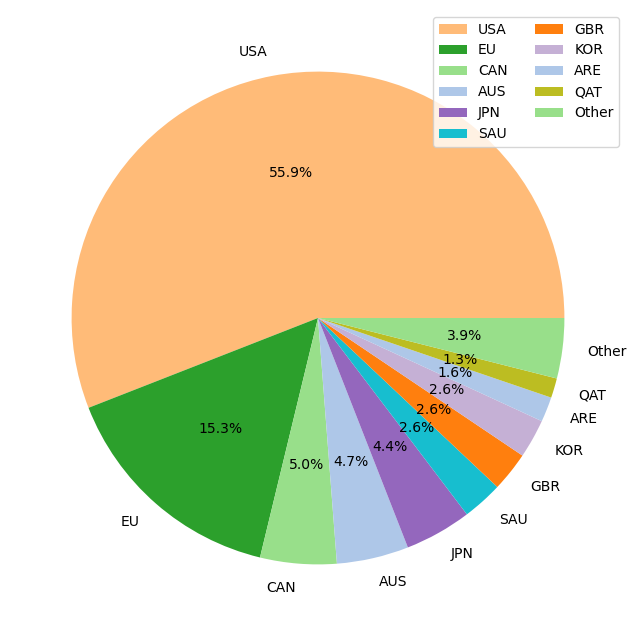

In [227]:
fs_share = fct.plot_prem_share(1, file_path=Path("C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis"))
for sce in premium_support_abs:
    for prem_mode in premium_support_abs[sce]:
        fs_share[f"{sce}_{prem_mode}_abs"] = fs_share['Share'] * premium_support_abs[sce][prem_mode]
        fs_share[f"{sce}_{prem_mode}_rel"] = fs_share['Share'] * premium_support_abs[sce][prem_mode] / (fs_share['GDP'] * 1000000) * 100

In [228]:
# Filter columns ending with '_rel' and '_abs'
rel_columns = fs_share.filter(like='_rel')
abs_columns = fs_share.filter(like='_abs')

# Calculate statistics across all '_rel' columns
rel_stats = rel_columns.aggregate(['mean', 'min', 'max']).mean(axis=1)

# Calculate statistics across all '_abs' columns
abs_stats = abs_columns.aggregate(['mean', 'min', 'max']).mean(axis=1)

# Display results
print("Statistics for '_rel' columns:")
print(rel_stats, '\n')

print("Statistics for '_abs' columns:")
print(abs_stats)

Statistics for '_rel' columns:
mean    0.004394
min     0.001268
max     0.016400
dtype: float64 

Statistics for '_abs' columns:
mean    6.390901e+07
min     3.418839e+04
max     1.680241e+09
dtype: float64


In [229]:
rel_stats = rel_columns.aggregate(['mean', 'min', 'max'])
abs_stats = abs_columns.aggregate(['mean', 'min', 'max'])
(rel_stats)
#(abs_stats)


,Sng_ibrd_rel,Sng_regression_rel,Sng_required_rel,S2_ibrd_rel,S2_regression_rel,S2_required_rel
mean,0.003557,0.004760,0.005557,0.003039,0.004469,0.004984
min,0.001026,0.001373,0.001603,0.000877,0.001289,0.001438
max,0.013277,0.017766,0.020739,0.011342,0.016679,0.018600


In [230]:
requ_cap = 0
for i in nominal_s2:
    requ_cap += (nominal_s2[i] -1000000000)
print(requ_cap + nominal_sng_dic[332])

42240615222.384995


In [231]:
nom_list = []
for cty in nominal_sng_dic:
    nom = nominal_sng_dic[cty]
    if nom <= 6000000000:
        nom_list.append(nominal_sng_dic[cty])
print(nom_list)

[5806034598.799549, 190385817.24421707, 316652842.90579146, 5146227622.931302, 307641548.3259832, 4853897062.094497, 508726260.0887032, 256554773.06744164, 1139625037.066101, 85861645.647796, 156119036.2551992, 17750172.83386383]


In [232]:
import pulp

def bin_packing_ilp(values, max_capacity):
    # Create a problem instance (Minimization problem)
    prob = pulp.LpProblem("Bin_Packing", pulp.LpMinimize)
    
    n = len(values)  # Number of items

    # Binary decision variables: z_ij, where z[i][j] is 1 if item i is in bin j
    z = pulp.LpVariable.dicts("z", (range(n), range(n)), cat='Binary')

    # Binary decision variable: y_j, where y[j] is 1 if bin j is used
    y = pulp.LpVariable.dicts("y", range(n), cat='Binary')

    # Objective function: Minimize the number of bins used
    prob += pulp.lpSum([y[j] for j in range(n)])

    # Constraint 1: Each item must be assigned to exactly one bin
    for i in range(n):
        prob += pulp.lpSum([z[i][j] for j in range(n)]) == 1

    # Constraint 2: The total sum of items in each bin cannot exceed the capacity
    for j in range(n):
        prob += pulp.lpSum([values[i] * z[i][j] for i in range(n)]) <= max_capacity * y[j]

    # Solve the problem
    prob.solve()

    # Extract the results
    groups = []
    for j in range(n):
        if pulp.value(y[j]) == 1:  # If bin j is used
            group = [i for i in range(n) if pulp.value(z[i][j]) == 1]
            if group:
                groups.append(group)

    return groups

# Example usage
max_capacity = 8000000000
groups = bin_packing_ilp(nom_list, max_capacity)
print(groups)


ModuleNotFoundError: No module named 'pulp'

In [54]:
from pooling_functions_ciullo import calc_pool_conc, PoolOptimizationProblem

sng_ann_losses = pd.read_csv("C:/Users/kaibe/Documents/ETH_Zurich/Thesis/Data/simulation_results/sng_losses_fs.csv")

RT = 10000
alpha = 1-1/RT 

df_losses = sng_ann_losses.copy()

cty_rd_s2 = [['212', '332', '548'], ['670', '776', '174', '584'], ['388', '242']]
rc_ls = []
for pool in cty_rd_s2:
    data_arr = df_losses[pool]
    bools = data_arr >= np.quantile(data_arr, alpha, axis=0)
    data_arr = data_arr.values
    bools = bools.values
    x = np.arange(0, len(pool))
    rc = 1 - calc_pool_conc(x, data_arr, bools, alpha)
    rc_ls.append(rc)
    print(rc)

print(f'Mean RC: {np.mean(rc_ls)}')


0.050000000000000044
0.45999999999999996
0.09999999999999998
Mean RC: 0.20333333333333334


In [241]:
coveragesss = []
for key in bond_metrics_sng_dic:
    print(bond_metrics_sng_dic[key]['Coverage'][0])
    coveragesss.append(bond_metrics_sng_dic[key]['Coverage'][0])
np.mean(coveragesss)

0.9269364488677819
0.9087342434241735
0.8804608037820908
0.9043548645216307
0.8996200198476368
0.8565295149655371
0.8994158220266757
0.8416185933761886
0.8746129972147898
0.8197440240394928
0.8028763264154536
0.5119849247318724
0.5231753848151861


0.8192356898483468